## 1.1 Model Hamiltonian

$$
    H = \frac{1}{2}\theta_1 \sigma_x - \frac{1}{2} \theta_2 \sigma_z
$$
where $\theta_1, \theta_2$ are model parameters. 

The target Hamiltonian acts on a wavefunction as $U = e^{-iHt}$. 

## 1.2 Quantum channels

We can thus define an effective channel generated by a target Hamiltonian, written in a Kraus representation
$$
    \Psi_H[\rho] = e^{-iHt} \rho e^{iHt}
$$
or instead as process matrix
$$
    K[H] \vec{\rho} = e^{-iHt} \otimes e^{-iHt} \vec{\rho} 
$$
(we're using a row-stack convention, where $\vec{\rho} = \sum {\rho_{i,j}} |i\rangle |j\rangle$) or finally using double bra-ket notation
$$
    = K[H] | \rho \rangle \rangle. 
$$

Thus, for this 1-qubit model, we define probabiliy for 0 (dark-state):
$$
    p_0(t) \equiv P(0|\theta_1, \theta_2, t) = \langle \langle E_0| K[H(t)] | \rho \rangle \rangle
$$
and 1 (light-state):
$$
    p_1(t) \equiv P(1|\theta_1, \theta_2, t) = \langle \langle E_1 |K[H(t)] | \rho \rangle \rangle
$$
where $E_\mu$ is a measurement effect corresponding to 0 and 1. In the computational basis, $E_0 = (1, 0, 0, 0)$ and $E_1 = (0, 0, 0, 1)$

## 1.3 Probabilities

Okay, so everything before was overkill. Since we're assuming that we prepare the 0 state perfectly, we can just use the simpiler 
$$
    p_0(t) = | \langle 0 | e^{-iUt} | 0 \rangle |^2
$$
and 
$$
    p_1(t) = | \langle 1 | e^{-iUt} | 0 \rangle |^2
$$

## 1.4 multinomial distribution

We'll use a multinomial distribution for the outcomes (okay it's a binomial here, but for 2+ qubits it'll be multinomial)

$$
f(x_0, x_1 | p_0, p_1, t) = {(x_0 + x_1)! \choose x_0! x_1!} (p_0(t))^{x_0} (p_1(t))^{x_1} 
$$

## 1.5 Likelihood 

The likelihood is then 

$$
L(\theta_1, \theta_2 | x_0, x_1) = \prod_t f(x_0(t), x_1(t) | p_0, p_1, t) = 
$$$$
     \prod_t {(x_0(t) + x_1(t))! \choose (x_0(t))! (x_1(t))!}   (p_0(t))^{x_0(t)} (p_1(t))^{x_1(t)} 
$$


## 1.2 Log-Likelihood 

The log-likelihood is 
$$
    O(\vec{x}_0, \vec{x}_1) = \sum_t \log {(x_0(t) + x_1(t))! \choose (x_0(t))! (x_1(t))!} + \sum_t x_0(t) \log p_0(t) + \sum_t x_1(t) \log p_1(t)
$$ 

In [5]:
using IonSim
using QuantumOptics: timeevolution, stochastic
using StochasticDiffEq
using ScikitLearn
using Random
using Optim
using Distributions
import PyPlot
const plt = PyPlot

PyPlot

## Define our trap

In [6]:
# defining trap parameters

ca_ion = Ca40(["S-1/2", "D-1/2"])
chain = LinearChain(
    ions=[ca_ion],
    com_frequencies=(x=3e6,y=3e6,z=1e6), 
    vibrational_modes=(;z=[1]),
)
laser = Laser(
    k = (x̂ + ẑ)/√2,
    ϵ = (x̂ - ẑ)/√2,
)
trap = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[laser])
laser.Δ = transition_frequency(trap, 1, ("S-1/2", "D-1/2"))

function simulate_trap(detuning, pi_time)
    Efield_from_pi_time!(pi_time, trap, 1, 1, ("S-1/2", "D-1/2"));  # Sets pi_time to 5 μs
    detuned_laser = copy(laser)
    detuned_laser.Δ += detuning

    trap.lasers = [detuned_laser]
    

    tspan = 0:0.1:40
    h = hamiltonian(trap, timescale=1e-6)
    mode = trap.configuration.vibrational_modes.z[1]
    @time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(trap, "S-1/2") ⊗ mode[0], h)
    ex = real.(expect(ionprojector(trap, "D-1/2"), sol))
    return tout, ex
end

simulate_trap (generic function with 1 method)

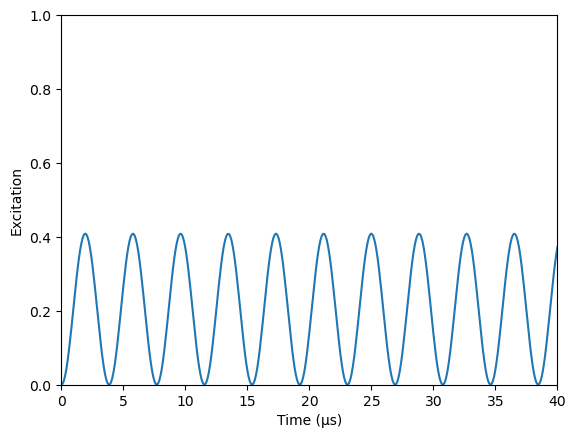

  8.204678 seconds (25.08 M allocations: 1.307 GiB, 8.14% gc time)


In [7]:
function simulate_trap(detuning, pi_time)
    Efield_from_pi_time!(pi_time, trap, 1, 1, ("S-1/2", "D-1/2"));  # Sets pi_time to 5 μs
    detuned_laser = copy(laser)
    detuned_laser.Δ += detuning

    trap.lasers = [detuned_laser]
    

    tspan = 0:0.1:40
    h = hamiltonian(trap, timescale=1e-6)
    mode = trap.configuration.vibrational_modes.z[1]
    @time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(trap, "S-1/2") ⊗ mode[0], h)
    ex = real.(expect(ionprojector(trap, "D-1/2"), sol))
    return tout, ex
end
tout, ex = simulate_trap(200e3, 3e-6)

plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

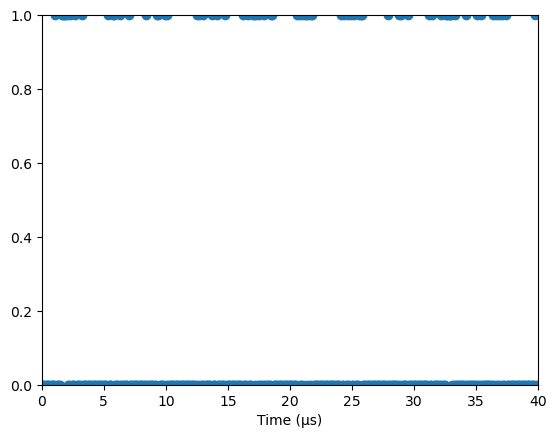

In [8]:
# function to simulate taking real data
function sample(timed_distro)
    samples = []
    for p in timed_distro
        number = rand(Float64)
        if p <= number
            push!(samples, 0)
        else
            push!(samples, 1)
        end
    end
    return samples
end

plt.scatter(tout, sample(ex))
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)");

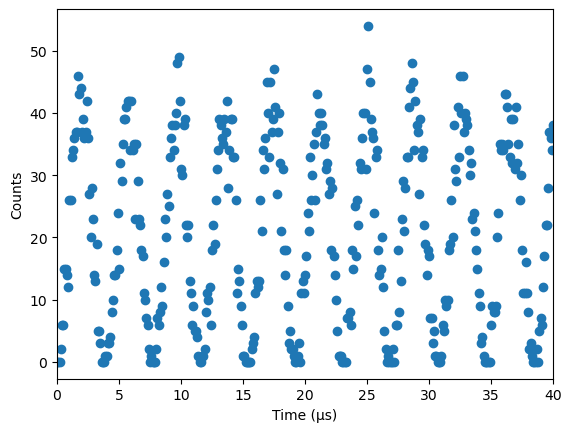

In [9]:
# simulate many experiements 
function simulate_experiment(N, timed_distro)
    counts = sample(timed_distro)
    for n = 2:N
        counts += sample(timed_distro)
    end
    return counts
end
        
plt.scatter(tout, simulate_experiment(100, ex))
plt.xlim(tout[1], tout[end])
plt.xlabel("Time (μs)")
plt.ylabel("Counts");

## Define our model, likelihood, and objective

In [10]:
# model building
sigX = [0 1; 1 0]
sigZ = [1 0; 0 -1]

function model_XZ(time, W₁, W₂, θ₁, θ₂)
    H = 0.5*(W₁*θ₁)*sigX - 0.5*(W₂ + θ₂)*sigZ
    U = exp(-im*H*time)
    return kron(U, U')
end

E₀ = [1, 0, 0, 0]
E₁ = [0, 0, 0, 1]
ρ₀ = [1, 0, 0, 0];


# let's just use the traditional pure state theory
function prob_1(time, θ₁, θ₂)
    H = 0.5*θ₁*sigX - 0.5*θ₂*sigZ
    U = exp(-im*H*time)
    return abs([0, 1]'*U*[1, 0])^2
end;

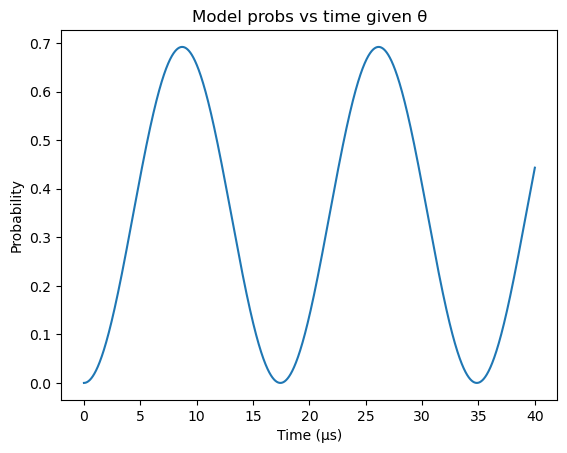

In [11]:
# model the the experimental outcomes
tspan = 0:0.01:40
outcomes = []
for t in tspan
    push!(outcomes,  prob_1(t, 0.3, 0.2))
end
plt.plot(tspan, outcomes)
plt.title("Model probs vs time given θ")
plt.xlabel("Time (μs)")
plt.ylabel("Probability");

In [12]:
function log_likelihood(bright_counts, num_experiments, times, θ₁, θ₂)
    out = 0
    for i in eachindex(times)
        p_1 = prob_1(times[i], θ₁, θ₂)
        dist = Multinomial(num_experiments, [1-p_1, p_1])
        term = logpdf(dist, [num_experiments-bright_counts[i], bright_counts[i]])
        if term != NaN
            out += term
        end
    end
    return out
end

log_likelihood (generic function with 1 method)

## Make some batches of data and optimize

In [13]:
N = 100
bright_counts = simulate_experiment(N, ex)

function objective(θ::Vector)
    return -log_likelihood(bright_counts, N, tout, θ[1], θ[2])
end

objective (generic function with 1 method)

In [14]:
log_likelihood(bright_counts, 100, tout, 0.6, 0.7)

-9364.494579520258

In [15]:
res = optimize(objective, [0.0, 0.0])

 * Status: success

 * Candidate solution
    Final objective value:     1.420153e+04

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    0
    f(x) calls:    4


In [16]:
Optim.minimizer(res)

2-element Array{Float64,1}:
 0.025
 0.0

## Okay now put it all together: 

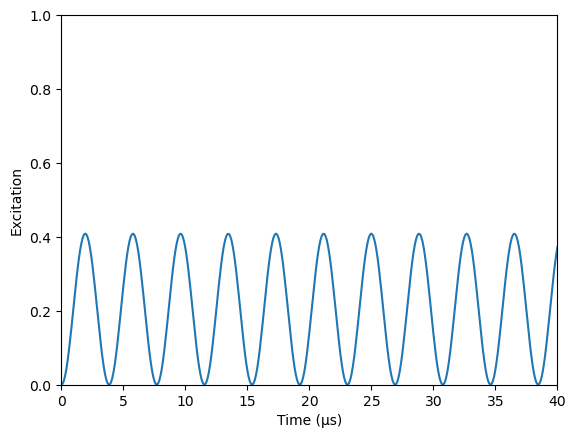

  0.009098 seconds (263.32 k allocations: 7.096 MiB)


In [17]:
function simulate_trap(detuning, pi_time)
    Efield_from_pi_time!(pi_time, trap, 1, 1, ("S-1/2", "D-1/2"));  # Sets pi_time to 5 μs
    detuned_laser = copy(laser)
    detuned_laser.Δ += detuning

    trap.lasers = [detuned_laser]
    

    tspan = 0:0.1:40
    h = hamiltonian(trap, timescale=1e-6)
    mode = trap.configuration.vibrational_modes.z[1]
    @time tout, sol = timeevolution.schroedinger_dynamic(tspan, ionstate(trap, "S-1/2") ⊗ mode[0], h)
    ex = real.(expect(ionprojector(trap, "D-1/2"), sol))
    return tout, ex
end
tout, ex = simulate_trap(200e3, 1e-6)

plt.plot(tout, ex)
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");

In [40]:
N = 5
bright_counts = simulate_experiment(N, ex)
function objective(θ::Vector)
    return -log_likelihood(bright_counts, N, tout, θ[1], θ[2])
end

objective (generic function with 1 method)

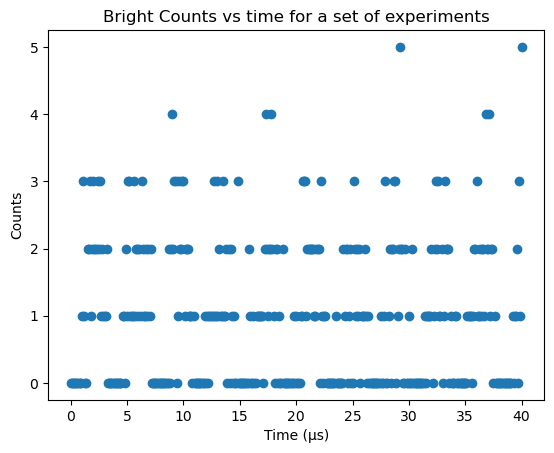

In [41]:
plt.scatter(tout, bright_counts)
plt.title("Bright Counts vs time for a set of experiments")
plt.xlabel("Time (μs)")
plt.ylabel("Counts");

In [42]:
res = optimize(objective, [1.0, 1.0])
θ₁, θ₂ = Optim.minimizer(res)


2-element Array{Float64,1}:
 1.0197293664180085
 1.2725496349272607

In [43]:
res

 * Status: success

 * Candidate solution
    Final objective value:     3.992197e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    44
    f(x) calls:    87


In [44]:
print(θ₁, '\n', θ₂)

1.0197293664180085
1.2725496349272607

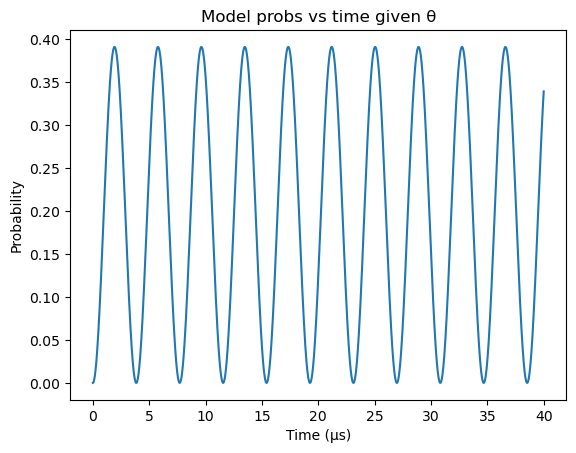

In [45]:
# model the the experimental outcomes
tspan = 0:0.01:40
outcomes = []
for t in tspan
    push!(outcomes,  prob_1(t, θ₁, θ₂))
end
plt.plot(tspan, outcomes)
plt.title("Model probs vs time given θ")
plt.xlabel("Time (μs)")
plt.ylabel("Probability");